<a href="https://colab.research.google.com/github/stanislawcronberg/Knapsack-Problem-with-Genetic-Algorithms/blob/main/Knapsack_(Genetic_Algorithms).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Solving the Knapsack Problem with Genetic Algorithms**

#### Table of Contents
1. The problem
2. A greedy algorithm
3. Genetic algorithms
4. Comparison of solutions


## 1. **The Problem**

We approach the knapsack problem as a combinatorial optimization problem. 

We have a knapsack (backpack or some container) that can hold a finite amount of weight and we have items we want to place in the knapsack. Each of these items has both a weight and value. 

**We want to maximize the total value of the items in the knapsack without going above the maximum load the knapsack can hold.** 

Some details to keep in mind:
- If we choose to include an item in the knapsack, we have to include all of it, we cannot take a fraction of an item
- We cannot place the same item more than once in our knapsack
- Once we have more items to place in the knapsack then it becomes difficult to check whether our solution is optimal
- Our measure of how good our current solution is how close we are to the maximum allowed weight on the knapsack 

First we define a class KnapsackProblem. For any instance of a knapsack problem that we want to consider, it will hold all the relevant information.

1. The value of each item
2. The weight of each item
3. The maximum weight the knapsack can hold
4. The number of items available to choose from

We also include two methods which will calculate the solutions total value and total weight given a list of decisions. This is a list of 1s and 0s of length equal to the number of items. 
- 0 means the item at that index is not included
- 1 means the item at that index is included

Later on we will be working strictly with decision lists, but for the first algorithm we consider, we allow the user to pass a list of the indices of the items that we are choosing to include in the knapsack. This is not the default behaviour.

**NOTE:** 
The values and weights lists have to be modified simultaneously. That is the value and weight of item with index **i** is the **ith** entry in the values and weights lists respectively.



In [ ]:
class KnapsackProblem():
    def __init__(self, values:list, weights:list, max_weight:float):
        self.values = values
        self.weights = weights
        self.max_weight = max_weight
        self.n_items = len(values)
        
    def solution_value(self, list_, is_decision_list=True):
        """
        Calculates the total value of our solution given either a list of indices of
        our items that we are choosing to add to our knapsack, or given a decision list
        of 1's and 0's
        """
        
        if is_decision_list:
            # dot product between our decision list and our values list
            return sum([list_[i] * self.values[i] for i in range(self.n_items)])
        else:
            return sum([self.values[index] for index in list_])
    
    
    def solution_weight(self, list_, is_decision_list=True):
        """
        Calculates the total weight of our solution given either a list of indices of
        our items that we are choosing to add to our knapsack, or given a decision list
        of 1's and 0's
        """
        
        if is_decision_list:
            # dot product between our decision list and our weight list
            return sum([list_[i] * self.weights[i] for i in range(self.n_items)])
        else:
            return sum([self.weights[index] for index in list_])

    def find_highest_weight(self):
        return max(self.weights)

With this we can now create an object of our knapsack problem.

In [ ]:
values = [5, 7, 8, 21, 5, 4, 7]
weights = [1, 2, 3, 4, 6, 5, 7]
max_weight = 15
problem = KnapsackProblem(values=values, weights=weights, max_weight=max_weight)

print("Problem max weight: ", problem.max_weight)
print("Problem highest weight for item: ", problem.find_highest_weight())
print("Values:  ", problem.values)
print("Weights: ", problem.weights)

Problem max weight:  15
Problem highest weight for item:  7
Values:   [5, 7, 8, 21, 5, 4, 7]
Weights:  [1, 2, 3, 4, 6, 5, 7]


## 2. **Greedy Solution**

We quickly take a look at a simple approach to finding a 'good enough' solution to the knapsack problem. 

Steps:
1. Sort the list of values and weights ordering them in descending order by the ratio value/weight
2. Select the highest ratio item in the list and attempt to add it to the knapsack (if it is possible to add this much more weight)
3. If the item is added, set the respective index in the decision list to 1, else set it to 0 and consider the next item.
4. The algorithm stops once we have looked once at each item in the list



In [ ]:
class GreedyKnapsack:
    
    def __init__(self, problem:KnapsackProblem):
        self.problem = problem 
    
    def solve(self, as_item_choices=True):
        """
        Applies the greedy algorithm to self.problem 

        as_item_choices  -  flag that determines the format of output,
                            either a decision list or the indices of items
                            that we are adding to the knapsack
        """

        curr_weight = 0 # current weight in the knapsack
        decisions = []  # list which will hold our decisions

        # retrieving the maximum weight our knapsack can hold
        max_weight = self.problem.max_weight

        # sorting our problem values as required by the greedy algorithm
        values, weights, indices = self.sort_values_weights()
        
        # filling our decisions list
        for weight in weights:
            if weight <= max_weight - curr_weight:
                decisions.append(1)
                curr_weight = curr_weight + weight
            else:
                decisions.append(0)
            # TODO: - is this part of the algorithm necessary?
            #       - do we want a decision list filled with zeros at the end?
            #           - we do if we were to use the output for our genetic algorithm
            # if curr_weight == max_weight:
            #     break
    
        item_choices = sorted([index for index, decision in zip(indices, decisions) if decision == 1])
        
        # return either the full decision list or the indices of the selected items
        if as_item_choices:
            return item_choices
        else:
            return decisions
    
    
    def sort_values_weights(self):
        """ 
        Sorting our lists of weights and values together with their indices 
        in descending order by the ratio (value/weight)
        """
        list_ = sorted(zip(self.problem.values, self.problem.weights, range(self.problem.n_items)), 
                       reverse = True, 
                       key = lambda pair: pair[0]/pair[1])

        return zip(*list_)

Now we can create an object of the problem and pass it to the GreedyKnapsack class and call the solve method to get a solution. 

In [ ]:
problem = KnapsackProblem(values=values, weights=weights, max_weight=max_weight)
greedy = GreedyKnapsack(problem)
greedy.solve(as_item_choices=False)

[1, 1, 1, 1, 0, 0, 1]

## 3. Genetic Algorithm

Another approach to solve the Knapsack Problem is with genetic algorithms. The aim is to create a population of solutions and interatively select the best performing ones (intentionally or randomly) and attempt to improve on them.

Basic intuition:
- We randomly generate a decision list for each chromosome (legal or not)
- There is a fitting_function which we want to optimize (in this case we want to maximize the value of our solution as long as it is legal)
- At each step of the algorithm we select part of the population of solutions that are performing the best and we 'mutate' them slightly in hope that some of them will be better than before

Aims:
- Understand better how genetic algorithms function and what their drawbacks are
- See how well they compare to the greedy algorithm presented above
- Figure out for this instance of the knapsack problem, what set of hyperparameters for the genetic algorithm will find the best solutions

Structure:
- Abstract class of Chromosome which will act as one solution
- Class of ChromosomeKnapsack which inherits the Chromosome class
- Population class which holds a list of our chromosomes (solutions)
- GeneticAlgorithm class which accepts a Population object and applies the algorithm to it



In [ ]:
from abc import ABC, abstractmethod

class Chromosome(ABC):
    """
    Abstract class for chromosome, requires the fitting_function and mutate
    """
    def __init__(self):
        # List of decisions the algorithm makes
        self.decisions = None

    def __str__(self):
        """ 
        Allows us to print a chromosomes decisions and its fit_score
        """
        return self.decisions.__str__() + "fit_score = " + str(self.fitting_function())

    @abstractmethod
    def fitting_function(self):
        """
        The function that the genetic algorithm will maximize or minimize
        """
        pass
    
    @abstractmethod
    def mutate(self, probability):
        """
        Slightly changes our solution with probability as a hyperparameter
        """
        pass


We defined an abstract class in this case since in the future we might want to solve a different kind of problem (not necessarily the knapsack problem) and then classes for applying the genetic algorithms themselves will be able to accept any chromosome, knapsack or not. 

### 3.1 ChromosomeKnapsack implementation
Main function:
- The fitting_function merely returns a dot product of the values list with the decision list as long of the solution is legal, for illegal solutions it returns -1
- cross_over performs the standard 1 point crossing over for 2 chromosomes

In [ ]:
import random
from copy import deepcopy

In [ ]:
class ChromosomeKnapsack(Chromosome):
    
    def __init__(self, problem:KnapsackProblem):
        # Object of our knapsack problem (contains weights/values/max_load/size)
        self.problem = problem 
        
        # Randomly initializing a solutions of our decision list
        self.decisions = random.choices([0, 1], weights=[1,1], k=problem.n_items) 
        
    def fitting_function(self):
        """
        Returns higher values for better solutions
        This is the function we want to minimize
        If a solution is not possible, return -1
        """
        if self.is_legal():
            return self.problem.solution_value(self.decisions)
        else:
            return -1
    
    def is_legal(self):
        """
        Checks if given solution (decision list) does not exceed the max_load
        """
        if self.problem.solution_weight(self.decisions) > self.problem.max_weight:
            return False
        else:
            return True
    
    def mutate(self, probability:float):
        """
        Changes decisions slightly with probability=probability
        probability: probability of modifying an element in our decisions list
        """
        
        # Create a copy of the current solution
        # TODO: consider if deepcopy is needed here or if a simple copy will suffice
        mod_decisions = deepcopy(self.decisions)
        
        # Choose which element of the solution list we are changing
        index = random.randint(0, self.problem.n_items - 1)
        
        # Modify the item in the list with probability=probability
        if random.random() <= probability: mod_decisions[index] = -mod_decisions[index] + 1
        
        # Create a copy of the chromosome
        new_chromosome = deepcopy(self)
        new_chromosome.decisions = mod_decisions
        
        return new_chromosome

    @staticmethod
    def cross_over(chromosome_a, chromosome_b) -> tuple:
        ''' Take 2 KnapsackChromosomes and returns 2. This function performs the 1 point crossing over'''
        
        # index to split on
        index = random.randint(1, len(chromosome_a.decisions) - 2)

        chromosome_c = deepcopy(chromosome_a)
        chromosome_c.decisions[index:] = chromosome_b.decisions[index:]

        chromosome_d = deepcopy(chromosome_b)
        chromosome_d.decisions[index:] = chromosome_a.decisions[index:]

        return chromosome_c, chromosome_d


In [ ]:
max_load = 10
values = [5, 7, 8, 21, 5]
weights = [1, 2, 3, 4, 6]

problem = KnapsackProblem(values, weights, max_load)
chrom_a = ChromosomeKnapsack(problem)
chrom_b = ChromosomeKnapsack(problem)

print("chrome_a:", chrom_a.decisions)
print("chrome_b:", chrom_b.decisions)

chrom_c, chrom_d = ChromosomeKnapsack.cross_over(chrom_a, chrom_b)

print("chrome_c:", chrom_c.decisions)
print("chrome_d:", chrom_d.decisions)


chrome_a: [0, 1, 0, 1, 1]
chrome_b: [1, 0, 1, 0, 0]
chrome_c: [0, 1, 1, 0, 0]
chrome_d: [1, 0, 0, 1, 1]


In [ ]:
max_load = 10
values = [5, 7, 8, 21, 5]
weights = [1, 2, 3, 4, 6]

problem = KnapsackProblem(values, weights, max_load)
chrom = ChromosomeKnapsack(problem)

# Legal solution
decisions = [0, 0, 0, 1, 1]
chrom.decisions = decisions
print("Decisions", decisions," is legal?", chrom.is_legal())
print("Fitting function", chrom.fitting_function(), '\n')

# Illegal solution
decisions = [1, 1, 1, 1, 1]
chrom.decisions = decisions
print("Decisions", decisions," is legal?", chrom.is_legal())
print("Fitting function", chrom.fitting_function(), '\n')

Decisions [0, 0, 0, 1, 1]  is legal? True
Fitting function 26 

Decisions [1, 1, 1, 1, 1]  is legal? False
Fitting function -1 



---
### **Population Class**

1. The population will hold a list of our chromosomes
2. We will keep a list of their scores from the fitting function
3. When modifying the chromosomes (mutating, crossing over, etc.) we will set the self._scores_updated flag to FALSE so that we know to update them again. We do this to avoid calling the fitting function too many times when it is not necessary (to be more computationally efficient)
4. We include a few different methods for selecting better or different chromosomes from the population
5. There are also method to plot the current state of the population, look at the distribution of scores across all chromosomes

##### **How we initialize the population**
- At first we simply initialize each chromosome randomly
- If the problem is not too difficult, this usually works
    - This gives us a quite diverse population as long as enough of the population has chromosomes which give allowed solutions
- When the problem is difficult, for e.g. we have many items to place in the knapsack but the maximum weight that the knapsack can hold is low, almost all randomly initialized chromosomes will not be legal solutions
    - In this case we use the weight of the heaviest item to randomly select a specified amount of items for each chromosome
    - As long as max_weight >= heaviest_item_weight * n_items, we know that we will have legal solutions

##### **Population size considerations**
- The larger the population is, the more computionally expensive it will be to iterate
- However a larger population means we have more diversity in our population
- Thus selecting the right population size involves selecting a population large enough to be diverse without being too expensive<
--- 

In [ ]:
from math import exp
import matplotlib.pyplot as plt
import statistics

In [ ]:
class Population:
    def __init__(self, size, chromosome_class, problem:KnapsackProblem):
        # population size (how many chromosomes we have at once active)  
        self.size = size

        # initialize our list of chromosomes
        self._members = [chromosome_class(problem) for _ in range(size)]

        # list of our fit scores
        self.__fit_scores = None

        # boolean flag which tells us if we need to update the __fit_scores
        # value if the population was altered/mutated
        self._scores_updated = False

        # we check if we got any legal solutions
        init_scores = [chrom.fitting_function() for chrom in self.members]

        # alter solution if most scores are illegal 
        if statistics.mean(init_scores) <= 0:
            highest_item_weight = problem.find_highest_weight()
            max_num_selected_items = int(problem.max_weight / highest_item_weight)

            for member in self.members:
                indices = random.choices(range(0, problem.n_items), k=max_num_selected_items)

                new_decisions = [0] * problem.n_items
                for index in indices:
                    new_decisions[index] = 1
                
                member.decisions = new_decisions
                


    @members.setter
    def members(self, value):
        self._members = value
        self._scores_updated = False

    @property
    def fit_scores(self):
        if self._scores_updated:
            return self.__fit_scores
        else:
            # Update the scores
            self.__fit_scores = [chrom.fitting_function() for chrom in self.members]

            # Change the flag to TRUE after updating scores
            self._scores_updated = True
            return self.__fit_scores

    def _calculate_scores(self, score_method=None):
        if score_method == "softmax":
            # exp(...) imported from math
            # return [exp(chrom.fitting_function()) for chrom in self.members]
            return [exp(score) for score in self.fit_scores]
        elif score_method == "ratio":
            # Add +2 since for illegal decision lists we have -1
            # return [chrom.fitting_function() + 2 for chrom in self.members]
            return [score + 2 for score in self.fit_scores]
        else:
            # Default fit score (includes -1 values for illegal decision lists)
            # return [chrom.fitting_function() for chrom in self.members]
            return self.fit_scores

    @staticmethod
    def _calculate_sample_probabilities(scores):
        total_score = sum(scores)
        return [score/total_score for score in scores]

    def select_parents_at_random(self):
        indices = random.sample(range(0, self.size), k=2)

        chrom_a = self.members[indices[0]]
        chrom_b = self.members[indices[1]]

        return chrom_a, chrom_b

    def select_parents_by_ratio(self):
        scores = self._calculate_scores("ratio")
        sample_probabilities = Population._calculate_sample_probabilities(scores)

        indices = random.choices(range(0, self.size), weights=sample_probabilities, k=2)

        chrom_a = self.members[indices[0]]
        chrom_b = self.members[indices[1]]

        return chrom_a, chrom_b

    def select_parents_softmax(self):
        scores = self._calculate_scores("softmax")
        sample_probabilities = Population._calculate_sample_probabilities(scores)

        indices = random.choices(range(0, self.size), weights=sample_probabilities, k=2)

        chrom_a = self.members[indices[0]]
        chrom_b = self.members[indices[1]]

        return chrom_a, chrom_b

    def select_parents_by_tournament(self, tournament_size=150):
        """
        Randomly selects tournament_size amount of chromosomes and selects 
        the 2 best ones
        """

        # Drawing indices randomly
        indices = random.choices(range(0, self.size), k=tournament_size)
        
        # Getting fit_scores for our selected indices
        # scores = [self.members[i].fitting_function() for i in indices]

        # Sorting indices in from highest to lowest
        sorted_indices = sorted(zip(indices, self.fit_scores),
                                reverse=True,
                                key= lambda x: x[1])
        
        # Selecting the two chromosomes from tournament with highest score
        # FIXED: incorrect indices before were being selected
        chrom_a = self.members[sorted_indices[0][0]]
        chrom_b = self.members[sorted_indices[1][0]]

        return chrom_a, chrom_b

    def view_fit_score(self):
        """
        Plots a histogram of the distribution of scores in the population
        """
        #scores = self._calculate_scores()
        plt.hist(self.fit_scores, bins=int(0.2*self.size))
        plt.title('Distribution of fit scores in the Population')
        plt.xlabel('Fit Score')
        plt.ylabel('Count')
        plt.show()

    def view_fit_score_probabilities(self):
        # select_parents_by_ratio
        scores_ratio = self._calculate_scores("ratio")
        scores_ratio = list(set(scores_ratio))
        sample_probabilities_ratio = Population._calculate_sample_probabilities(scores_ratio)

        # select_parents_softmax
        scores_soft = self._calculate_scores("softmax")
        scores_soft = list(set(scores_soft))
        sample_probabilities_soft = Population._calculate_sample_probabilities(scores_soft)

        plt.scatter(scores_ratio, sample_probabilities_ratio)
        plt.xlabel('score')
        plt.ylabel('sample probability')
        plt.title('Ratio')
        plt.show()

        plt.scatter(scores_soft, sample_probabilities_soft)
        plt.xlabel('score')
        plt.ylabel('sample probability')
        plt.title('Softmax')
        plt.show()

a1:  [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0]fit_score = -1
b1:  [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0]fit_score = 36 

a2:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0]fit_score = 54
b2:  [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1]fit_score = 69 

a3:  [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]fit_score = 79
b3:  [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1]fit_score = 80 

a4:  [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]fit_score = -1
b4:  [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1]fit_score = 43 



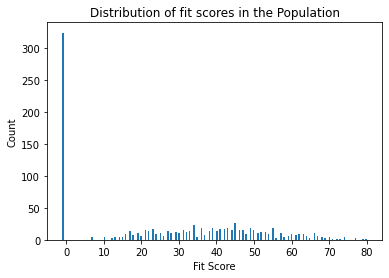

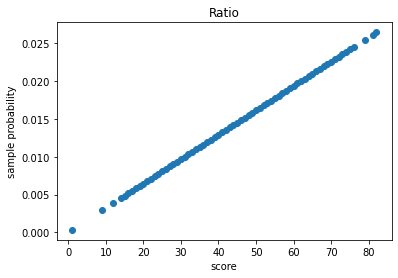

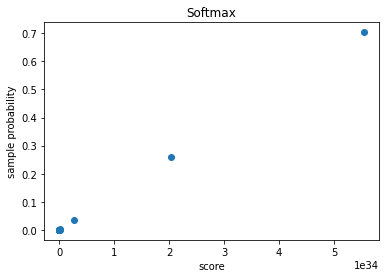

In [ ]:
max_load = 20
values = [5, 7, 8, 21, 5, 4, 7, 22, 3, 2, 9]
weights = [1, 2, 3, 4, 6, 5, 7, 2, 1, 4, 1]

problem = KnapsackProblem(values, weights, max_load)
my_population = Population(1000, ChromosomeKnapsack, problem)

chrom_a1, chrom_b1 = my_population.select_parents_at_random()
print("a1: ", chrom_a1)
print("b1: ", chrom_b1, '\n')

chrom_a2, chrom_b2 = my_population.select_parents_by_ratio()
print("a2: ", chrom_a2)
print("b2: ", chrom_b2, '\n')

chrom_a3, chrom_b3 = my_population.select_parents_softmax()
print("a3: ", chrom_a3)
print("b3: ", chrom_b3, '\n')

chrom_a4, chrom_b4 = my_population.select_parents_by_tournament()
print("a4: ", chrom_a4)
print("b4: ", chrom_b4, '\n')

my_population.view_fit_score()

my_population.view_fit_score_probabilities()

In [ ]:
import tqdm       # progress bar

In [ ]:
class GeneticAlgorithm():
    def __init__(self, population:Population):
        self.population = population

    def _is_odd(self):
        is_odd = False
        if self.population.size % 2 != 0:
            is_odd = True
        return is_odd

    def _select_new_members(self, select_method="softmax"):
        """
        Selects new members of our population which we will after mutate
        
        select_method  -  method by which we will select new members
        """
        pop_size = self.population.size
        is_odd = self._is_odd()

        if select_method == "softmax":
            new_members = [item for item in self.population.select_parents_softmax() for _ in range(0, int(pop_size/2))]
            if is_odd: new_members.append(self.population.select_parents_softmax()[0])
        elif select_method == "random":
            new_members = [item for item in self.population.select_parents_at_random() for _ in range(0, int(pop_size/2))]
            if is_odd: new_members.append(self.population.select_parents_at_random()[0])
        elif select_method == "tournament":
            new_members = [item for item in self.population.select_parents_by_tournament() for _ in range(0, int(pop_size/2))]
            if is_odd: new_members.append(self.population.select_parents_by_tournament()[0])
        elif select_method == "ratio":
            new_members = [item for item in self.population.select_parents_by_ratio() for _ in range(0, int(pop_size/2))]
            if is_odd: new_members.append(self.population.select_parents_by_ratio()[0])

        return new_members

    @staticmethod
    def view_fit_scores(mean_scores, max_scores, fit_method):
        n_iter = len(mean_scores)

        plt.plot(range(0, n_iter), mean_scores, label="mean score")
        plt.plot(range(0, n_iter), max_scores, label="max score")
        plt.legend()
        plt.xlabel("number iterations")
        plt.ylabel("fit score")
        plt.title(fit_method)
        plt.show()

    def _replace_population_with_new_mutated_members(self, new_members, probability=0.5):
        mutated_members = [member.mutate(probability=probability) for member in new_members]
        self.population.members = mutated_members
        
    def fit(self, n_iter=100, probability=0.5, select_method="softmax", 
            elitism=False, plot_scores=True):
        """
        n_iter       - how many times we iterate the algorithm
        probability  - with what probability do we mutate a chromosome
        modify_ratio - what ratio of the best chromosomes do we mutate,
                       and what ratio of the worst chromosomes do we remove
        """
        
        mean_scores = []
        max_scores = []

        # init_fit_scores = self.population._calculate_fit_scores()
        init_fit_scores = self.population.fit_scores

        mean_scores.append(statistics.mean(init_fit_scores))
        max_scores.append(max(init_fit_scores))

        for i in tqdm.tqdm(range(n_iter)):
            # Select new members for our population
            # new_members = [item for item in self.population.select_parents_softmax() for _ in range(0, int(self.population.size / 2))]

            # Add a single extra chromosome if we are dealing with an odd sized population
            # if self._is_odd(): new_members.append(self.population.select_parents_softmax()[0])

            new_members = self._select_new_members(select_method)

            # Save elite solution in the current population first
            if elitism:
                # What percentage of the population do we want to save
                ratio = 0.1
                # How many chromosomes are we saving
                n_leaders = int(ratio * self.population.size)

                curr_fit_scores = deepcopy(self.population.fit_scores)
                # Finding the indices of the best scores
                sorted_indices_scores = sorted(zip(curr_fit_scores, range(0,self.population.size)),
                                               reverse=True,
                                               key = lambda pair: pair[0])
                
                _, sorted_indices = zip(*sorted_indices_scores)
                leader_indices = sorted_indices[:n_leaders]

                leader_chromosomes = [deepcopy(self.population.members[i]) for i in leader_indices]


            # Mutate our new population members
            # new_members_mutated = [member.mutate(probability=probability) for member in new_members]
            # self.population.members = new_members_mutated
            self._replace_population_with_new_mutated_members(new_members=new_members, 
                                                              probability=probability)
            
            # Overrite worst solutions in mutated population with our elite
            # solutions
            if elitism:
                self.population.members = sorted(self.population.members,
                                                 reverse=False, # We want the worst scores first
                                                 key = lambda member: member.fitting_function())

                self.population.members[:n_leaders] = leader_chromosomes
                

            # Getting mean and max score for population
            # fit_scores = [chrom.fitting_function() for chrom in new_members]
            fit_scores = [chrom.fitting_function() for chrom in self.population.members]
            # fit_scores = self.population.fit_scores
            mean_scores.append(statistics.mean(fit_scores))
            max_scores.append(max(fit_scores))

            # TODO: Add crossover here somewhere

            # TODO: Add elitism - best 5% of scores are in the new population
            #                   - they are not mutated/crossover

        if plot_scores:
            GeneticAlgorithm.view_fit_scores(mean_scores, max_scores, select_method)

In [ ]:
def generate_values_weights_maxweight(n_items = 50, max_value = 20):
    values = [random.randint(1, max_value) for _ in range(0, n_items)]
    weights = [random.randint(1, max_weight) for _ in range(0, n_items)]
    maxweight = 100

    return values, weights, maxweight

100%|██████████| 200/200 [00:09<00:00, 20.68it/s]


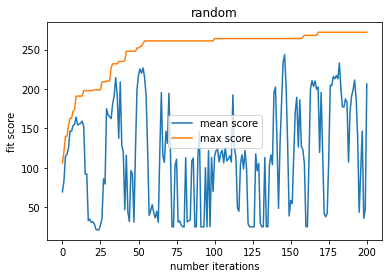

100%|██████████| 200/200 [00:10<00:00, 19.37it/s]


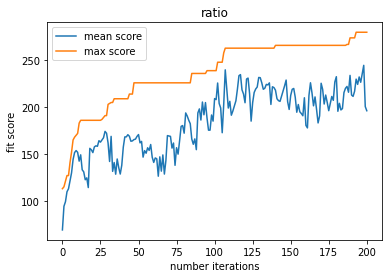

100%|██████████| 200/200 [00:10<00:00, 19.68it/s]


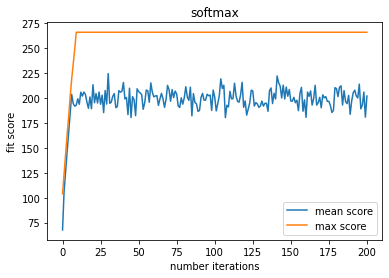

100%|██████████| 200/200 [00:09<00:00, 20.28it/s]


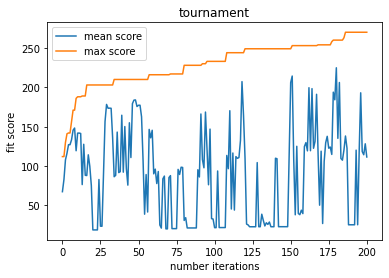

In [ ]:
# max_weight = 40
# values = [5, 7, 8, 21, 5, 4, 7, 22, 3, 2, 9, 24, 1]
# weights = [1, 2, 3, 4, 6, 5, 7, 2, 1, 4, 1, 5, 20]

random.seed(12)

values, weights, max_weight = generate_values_weights_maxweight()

problem = KnapsackProblem(values, weights, max_weight)

population_size = 200
# print("population random init start")
my_population_random = Population(population_size, ChromosomeKnapsack, problem)

# print("population ratio init start")
my_population_ratio = Population(population_size, ChromosomeKnapsack, problem)

# print("population softmax init start")
my_population_softmax = Population(population_size, ChromosomeKnapsack, problem)

# print("population tournament init start")
my_population_tournament = Population(population_size, ChromosomeKnapsack, problem)

n_iter = 200

# TODO: When there are many items to choose from with high enough weights, 
#       it becomes very difficult to randomly initialize a chromosome that 
#       is not illegal.
#
#       If all solutions (or a large enough percentage of the population are illegal),
#       we should try to figure out a way to select the initial items more carefully
#
#       Potential solutions:
#       1. Limiting how many items are initialized (base it off the maximum weight of one item)
#       2. Figuring out a way to find better chromosomes among the illegal ones
#           - The closer to the max_weight the better

# ELITISM FLAG
elitism = True

# RANDOM parents select method
genetic_random = GeneticAlgorithm(my_population_random)
genetic_random.fit(n_iter=n_iter, select_method="random", elitism=elitism)

# RATIO parents select method
genetic_ratio = GeneticAlgorithm(my_population_ratio)
genetic_ratio.fit(n_iter=n_iter, select_method="ratio", elitism=elitism)

# # SOFTMAX parents select method
genetic_softmax = GeneticAlgorithm(my_population_softmax)
genetic_softmax.fit(n_iter=n_iter, select_method="softmax", elitism=elitism)

# # TOURNAMENT parents select method
genetic_tournament = GeneticAlgorithm(my_population_tournament)
genetic_tournament.fit(n_iter=n_iter, select_method="tournament", elitism=elitism)

### Observations (only using mutate with probability = 50% and no elitism)

- Random
    - Unless the problem is quite easy, the random algorithm does not work well
    - It could however get lucky and by elitism yield a good solution in the end
    - Choosing a more informed algorithm could help us find a better solution in a lower amount of iterations

- Ratio
    - More informed than randomly selecting parents
    - By not giving too much weight to the best solution it still often will select less optimal solutions for the parents yielding a greater population diversity
    - More likely to find a better solution than random selection of parents

- Softmax
    - Gives higher weights to the better solutions
    - More likely to get stuck in local minima (without elitism)
    - Less population diversity
